
# Music Metadata Recommender System

##### Group Members: Rithvik Sunku, Angikaar Singh Chana & Matthew Dodd

## 1. Problem Statement

The problem we are addressing: Song/Playlist recommendation given a user inputted playlist

    -Can we use song metadata to effectively predict songs which are similar to those a user already listens to?
    -Can we make these Hyper personalized?
    -Can we add a feedback loop for potential model refinement?

## 2. Dataset

Dataset 1: Spotify Song Metadata

    -Dataset of Song Metadata
    -Primary dataset consists of descriptors for 170,653 unique songs
    -4 additional datasets that aggregate by different factors i.e Genre/artist/year
    -These are more limited with only 28680

Dataset 2: Spotify Python API

    -API to fetch data regarding spotifies catalogue

Dataset 3: Spotify User playlist dataset

    -Dataset containing unique user playlists
    -Could be used to do a collaborative filtering approach

In [20]:
pip install lyricsgenius

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 kB 3.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.decomposition import PCA
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import os
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import lyricsgenius
from textblob import TextBlob

# EDA and Feature Extraction

In [4]:
data = pd.read_csv('/content/drive/MyDrive/**Academics**/data.csv')
data

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.98200,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.6650,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.73200,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.1600,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.96100,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.1010,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.96700,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.3810,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.95700,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.2290,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170648,0.6080,2020,0.08460,"['Anuel AA', 'Daddy Yankee', 'KAROL G', 'Ozuna...",0.786,301714,0.808,0,0KkIkfsLEJbrcIhYsCL7L5,0.000289,7,0.0822,-3.702,1,China,72,2020-05-29,0.0881,105.029
170649,0.7340,2020,0.20600,['Ashnikko'],0.717,150654,0.753,0,0OStKKAuXlxA0fMH54Qs6E,0.000000,7,0.1010,-6.020,1,Halloweenie III: Seven Days,68,2020-10-23,0.0605,137.936
170650,0.6370,2020,0.10100,['MAMAMOO'],0.634,211280,0.858,0,4BZXVFYCb76Q0Klojq4piV,0.000009,4,0.2580,-2.226,0,AYA,76,2020-11-03,0.0809,91.688
170651,0.1950,2020,0.00998,['Eminem'],0.671,337147,0.623,1,5SiZJoLXp3WOl3J4C8IK0d,0.000008,2,0.6430,-7.161,1,Darkness,70,2020-01-17,0.3080,75.055


In [5]:
"""Overview of columns"""

data.columns

Index(['valence', 'year', 'acousticness', 'artists', 'danceability',
       'duration_ms', 'energy', 'explicit', 'id', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'name', 'popularity', 'release_date',
       'speechiness', 'tempo'],
      dtype='object')

In [6]:
"""Overview of data"""

data.describe()

,valence,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
count,170653.000000,170653.000000,170653.000000,170653.000000,1.706530e+05,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000
mean,0.528587,1976.787241,0.502115,0.537396,2.309483e+05,0.482389,0.084575,0.167010,5.199844,0.205839,-11.467990,0.706902,31.431794,0.098393,116.861590
std,0.263171,25.917853,0.376032,0.176138,1.261184e+05,0.267646,0.278249,0.313475,3.515094,0.174805,5.697943,0.455184,21.826615,0.162740,30.708533
min,0.000000,1921.000000,0.000000,0.000000,5.108000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000
25%,0.317000,1956.000000,0.102000,0.415000,1.698270e+05,0.255000,0.000000,0.000000,2.000000,0.098800,-14.615000,0.000000,11.000000,0.034900,93.421000
50%,0.540000,1977.000000,0.516000,0.548000,2.074670e+05,0.471000,0.000000,0.000216,5.000000,0.136000,-10.580000,1.000000,33.000000,0.045000,114.729000
75%,0.747000,1999.000000,0.893000,0.668000,2.624000e+05,0.703000,0.000000,0.102000,8.000000,0.261000,-7.183000,1.000000,48.000000,0.075600,135.537000
max,1.000000,2020.000000,0.996000,0.988000,5.403500e+06,1.000000,1.000000,1.000000,11.000000,1.000000,3.855000,1.000000,100.000000,0.970000,243.507000


In [7]:
""" Null values check"""

data.isnull().sum()

valence             0
year                0
acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
explicit            0
id                  0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
name                0
popularity          0
release_date        0
speechiness         0
tempo               0
dtype: int64

In [8]:
"""Frequency that artists show up"""

artist_count = data['artists'].value_counts().reset_index()

artist_count.head(10)

,index,artists
0,['Эрнест Хемингуэй'],1211
1,['Эрих Мария Ремарк'],1068
2,['Francisco Canaro'],942
3,['Frank Sinatra'],630
4,['Ignacio Corsini'],628
5,['Elvis Presley'],504
6,['Johnny Cash'],484
7,['Bob Dylan'],474
8,['The Rolling Stones'],471
9,['The Beach Boys'],455


In [9]:
"""Most Popular Artists"""

popularity = data.groupby(['artists'])['popularity'].mean().reset_index()

popularity.sort_values(by = ['popularity'], ascending=False).head(10)

,artists,popularity
2831,"['Bad Bunny', 'Jhay Cortez']",100.0
443,"['24kGoldn', 'iann dior']",99.0
4932,"['Cardi B', 'Megan Thee Stallion']",96.0
16254,"['Justin Bieber', 'benny blanco']",95.0
15078,"['Joel Corry', 'MNEK']",94.0
26734,"['Sech', 'Daddy Yankee', 'J Balvin', 'ROSALÍA'...",94.0
25530,['Ritt Momney'],93.0
8155,"['Drake', 'Lil Durk']",93.0
17903,"['Lele Pons', 'Guaynaa']",92.0
19958,"['Manuel Turizo', 'Rauw Alejandro', 'Myke Towe...",92.0


<Axes: xlabel='year', ylabel='count'>

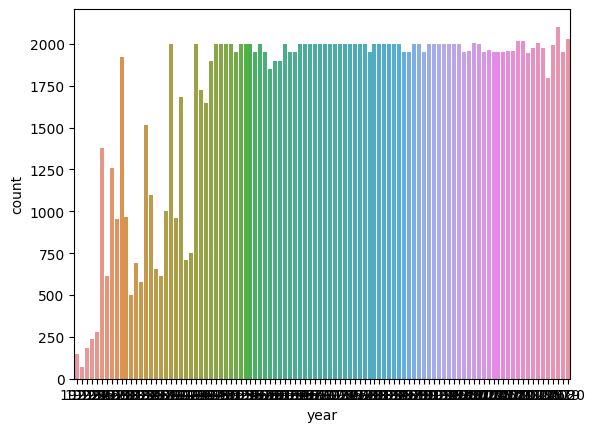

In [10]:
"""Data by year"""

sns.countplot(x='year', data=data)

In [11]:
"""Trend of song length"""
year_data = pd.read_csv('/content/drive/MyDrive/**Academics**/data_by_year.csv')
fig = px.line(year_data, x='year', y='duration_ms',title='Trend of song duration over decades')
fig.show()

<ipython-input-12-e988898f678f>:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

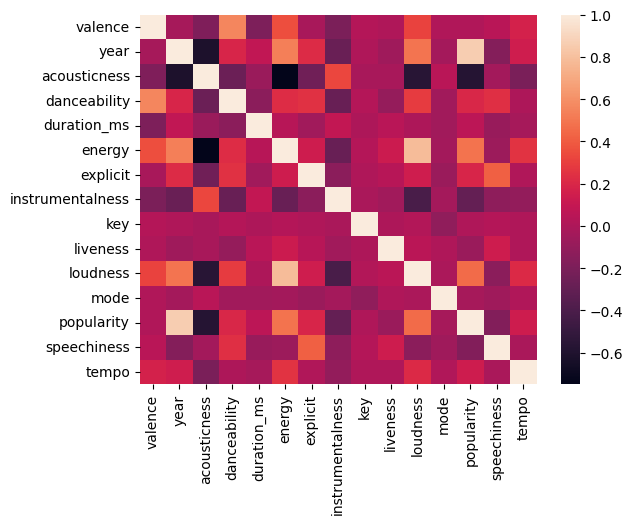

In [12]:
"""Categorical Correlations"""

sns.heatmap(data.corr())

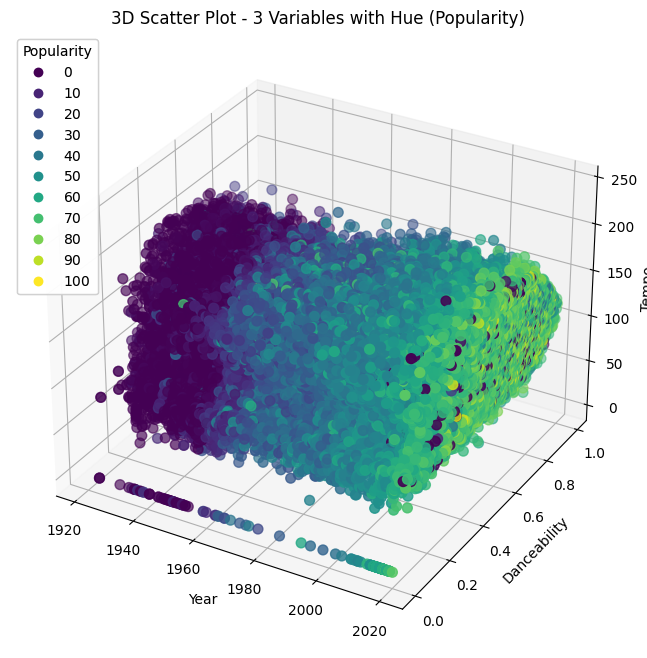

In [13]:
""" Visual of clusters on three varaibles"""
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(data['year'], data['danceability'], data['tempo'], c=data['popularity'], s=50, cmap='viridis')
legend = ax.legend(*scatter.legend_elements(), title='Popularity')
ax.add_artist(legend)

ax.set_xlabel('Year')
ax.set_ylabel('Danceability')
ax.set_zlabel('Tempo')
ax.set_title('3D Scatter Plot - 3 Variables with Hue (Popularity)')
plt.show()

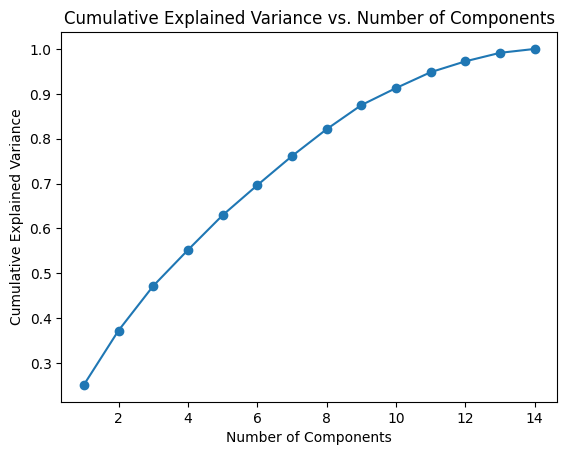

In [14]:
# Remove duplicates and irrelevant columns
filtered_data = data.drop_duplicates(subset=['id'])
filtered_data = filtered_data.drop(['id', 'name', 'artists', 'popularity','release_date'], axis=1)

# Normalize the data
scaler = StandardScaler()
data_norm = scaler.fit_transform(filtered_data)

# Instantiate PCA with the number of components you want to test
n_components = 14
pca = PCA(n_components=n_components)

# Fit and transform your data with PCA
pca.fit(data_norm)
variance = pca.explained_variance_ratio_

# Create a cumulative sum of the explained variance
cumulative_variance = np.cumsum(variance)

# Plot the cumulative explained variance
plt.plot(range(1, n_components+1), cumulative_variance, '-o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.show()

# Adding Features using NLP - Angi

In [22]:
genius_access_token = "BjmNmgvV-82TwCIkUEQ9GLI12RwvUJSHaQvE4o4jjMZ_gdThPBG6OMlvBAO8m7Kx"

def fetch_lyrics(song_title, artist_name):
    genius = lyricsgenius.Genius(genius_access_token, remove_section_headers=True, skip_non_songs=True, excluded_terms=["(Remix)", "(Live)"], retries=3)
    song = genius.search_song(song_title, artist_name)
    
    if song:
        return song.lyrics
    else:
        return None

In [ ]:
def fetch_lyrics_for_playlist(playlist):
    lyrics_dict = {}

    for song in playlist:
        song_title = song["title"]
        artist_name = song["artist"]

        lyrics = fetch_lyrics(song_title, artist_name)

        if lyrics:
            lyrics_dict[song_title] = lyrics
        else:
            print(f"Lyrics not found for {song_title} by {artist_name}.")

    return lyrics_dict

lyrics_dict = fetch_lyrics_for_playlist(user_playlist)



In [ ]:
def sentiment_analysis(lyrics):
  text = TextBlob(lyrics)
  return text.sentiment.polarity, text.sentiment.subjectivity

sentiment_scores = {}
for song_title, lyrics in lyrics_dicts:
  sentiment_scores[song_title] = sentiment_analysis(lyrics)

# Enter code here that takes these sentiment scores and somehow updates them to
# the provided playlists for use in the rerun of the algorithm

# Model Training and Refinement

In [15]:
# Prompt the user to connect their Spotify account
os.environ["SPOTIPY_CLIENT_ID"] = "3f4df87b4c02420eb9a912c85f716bd9"
os.environ["SPOTIPY_CLIENT_SECRET"] = "c04385fe4e81432282085494051a59d6"
os.environ["SPOTIPY_REDIRECT_URI"] = "http://localhost:8000/callback/"
scope = "user-library-read playlist-read-private playlist-modify-public playlist-modify-private"
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope, cache_path=".spotifycache"))

# Final Model

In [16]:
# Get the user's playlist
user_playlists = sp.current_user_playlists(limit=10)
print("Your playlists:")
for i, playlist in enumerate(user_playlists['items']):
    print(f"{i+1}. {playlist['name']}")
playlist_choice = input("Enter the number of the playlist you want to use for recommendations: ")
playlist_id = user_playlists['items'][int(playlist_choice)-1]['id']
playlist_tracks = sp.playlist_tracks(playlist_id)['items']
user_playlist = [track['track']['id'] for track in playlist_tracks]

try:
    exists = data["user_rating"]
except:
    data["user_rating"] = np.ones(len(data)) #intialize rating column
          
while True:
    #[TRAINING STAGE]
    print('Retraining and Fitting Dataset...')
    n = 5
    # Normalize the data
    filtered_training_data = data.drop(['id', 'name', 'artists','release_date'], axis=1)
    scaler = StandardScaler()
    data_norm = scaler.fit_transform(filtered_training_data)

    # Cluster the songs using KMeans
    kmeans = KMeans(n_clusters=n, random_state=0)
    kmeans.fit(data_norm)
    clusters_kmeans = kmeans.predict(data_norm)

    # Cluster the songs using GMMs
    gmm = GaussianMixture(n_components=n, random_state=0)
    gmm.fit(data_norm)
    clusters_gmm = gmm.predict(data_norm)

    # Combine the clusters using ensemble approach
    clusters_combined = []
    for i in range(len(data)):
        if clusters_kmeans[i] == clusters_gmm[i]:
            clusters_combined.append(clusters_kmeans[i])
        else:
            clusters_combined.append(kmeans.predict(data_norm[i].reshape(1, -1))[0])
    clusters_combined = pd.Series(clusters_combined)

    # Calculate the Silhouette score for the combined clusters
    combined_silhouette = silhouette_score(data_norm, clusters_combined)
    print("Combined Silhouette score:", combined_silhouette)
          
    #[RECCOMENDATION STAGE]
    # Filter the Kaggle dataset to only include songs that are not in the user's playlist
    data_filtered = data.loc[~data['id'].isin(user_playlist)]

    # Recommend songs to the user
    user_data = data.loc[data['id'].isin(user_playlist)].drop(['id', 'name', 'artists', 'release_date'], axis=1)
    user_data_scaled = scaler.transform(user_data)
    user_cluster_kmeans = kmeans.predict(user_data_scaled)
    user_cluster_gmm = gmm.predict(user_data_scaled)
    user_cluster_combined = user_cluster_kmeans if (user_cluster_kmeans == user_cluster_gmm).all() else kmeans.predict(user_data_scaled)
    recommended_songs = data.loc[np.isin(clusters_combined,user_cluster_combined)].sample(n=10)['id'].tolist()
    
    # Print the recommended songs and their links
    print("Recommended songs:")
    for i, song_id in enumerate(recommended_songs):
        song_name = sp.track(song_id)['name']
        song_artist = sp.track(song_id)['artists'][0]['name']
        print(f"{i+1}. {song_name} - {song_artist}")

    # Ask the user to rate the recommended songs and add highly rated songs to the new playlist
    ratings = []
    new_songs = []
    for song_id in recommended_songs:
        song_link = sp.track(song_id)['external_urls']['spotify']
        print(f"Song Link Here: {song_link}")
        rating = input(f"On a scale of 1-10, how much do you like the song {sp.track(song_id)['name']} by {sp.track(song_id)['artists'][0]['name']}? Type esc to get new recommendations.")
        
        if rating == 'esc':
            break
        ratings.append(int(rating))
        if int(rating) >= 7:
            new_songs.append(song_id)
            data.loc[data["id"] == song_id, "user_rating"] = rating
    if new_songs:
        sp.user_playlist_add_tracks(user=sp.me()['id'], playlist_id=playlist_id, tracks=new_songs)
        print(f"{len(new_songs)} highly rated songs added to your new playlist!")
    

    # Check if the user is satisfied with the recommendations
    satisfied = input("Are you satisfied with the recommendations? Say yes to exit (y/n)")
    if satisfied in "yes":
        data.to_csv('data.csv')
        break

KeyboardInterrupt: ignored

# Evaluation Testing

# Create GUI?